File for reading in MODIS Earthdata to assess global surface coverage.

In [2]:
import h5py
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Get all files that end in .h5 in the specified directory
directory = '/Users/shockblack/Documents/data/EarthdataDownload/MCD12C1_061-20250404_212335'
h5_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.h5')]

# MODIS observations are 3600x7200 pixels (latitude x longitude)
# Create latitude weights
latitudes = np.linspace(-90, 90, 3600)
latitude_weights = np.cos(np.radians(latitudes))

# Normalize the weights
latitude_weights /= latitude_weights.sum()

# Read in each of the files with xarray and get the surface percentages
percentage_arrs = []
for file in h5_files:
    # Open the HDF5 file with xarray
    ds = xr.open_dataset(file, engine='h5netcdf', group='MOD12C1/Data Fields', decode_times=False)

    assessment = ds['Majority_Land_Cover_Type_1_Assessment'].values
    data = ds['Land_Cover_Type_1_Percent'].values

    # Apply the latitude weighting to calculate the weighted percent coverage
    weighted_land_cover_percent = np.sum(np.sum(data, axis=1) * latitude_weights[:, np.newaxis], axis=0)

    # Normalize the weighted land cover percentages
    weighted_land_cover_percent /= weighted_land_cover_percent.sum()
    
    # Append the result to the list
    percentage_arrs.append(weighted_land_cover_percent)

# Averaged over all files (2010-2020, inclusive)
surface_percentages = np.mean(percentage_arrs, axis=0)
# Renormalize the surface percentages (Just in case)
surface_percentages /= surface_percentages.sum()

In [3]:
surface_percentages
labels = [
    "Water",
    "Evergreen Needleleaf Forest", # Engelmann (USGS) XXX
    "Evergreen Broadleaf Forest", # Magnolia Grandiflora (ECOSTRESS) XXX
    "Deciduous Needleleaf Forest", # Engelmann (USGS) XXX
    "Deciduous Broadleaf Forest", # Aspen (USGS) XXX
    "Mixed Forest", # Do equal weighting of all trees XXX
    "Closed Shrubland", # Adenostoma fasciculatum (ECOSTRESS) XXX
    "Open Shrubland", # 30% Adenostoma fasciculatum (ECOSTRESS), 70% Reddish brown fine sandy loam (ECOSTRESS) XXX
    "Woody Savanna", # Acacia Visco (ECOSTRESS) XXX
    "Savanna", # Rangeland (USGS) XXX
    "Grassland", # Rangeland  51% Grass (USGS) XXX
    "Permanent Wetland", # Wetland (USGS) XXX
    "Cropland", # Jennewein et al. 2024 (Fresh Cut Wheat Residue) XXX
    "Urban and Built-Up", # Asphaltic Concrete (ECOSTRESS) XXX
    "Cropland/Natural Vegetation Mosaic", # Jennwein et al. 2024 (Fresh Cut Wheat Residue) XXX
    "Snow and Ice", # Zeng et al. 1984 (glacial ice) XXX
    "Barren or Sparsely Vegetated", # Quartz Ottawa Sand (USGS) XXX
]

for i, label in enumerate(labels):
    print(f"{label}: {surface_percentages[i] * 100:.2f}%")

Water: 71.57%
Evergreen Needleleaf Forest: 0.49%
Evergreen Broadleaf Forest: 2.36%
Deciduous Needleleaf Forest: 0.09%
Deciduous Broadleaf Forest: 0.58%
Mixed Forest: 0.93%
Closed Shrubland: 0.12%
Open Shrubland: 2.57%
Woody Savanna: 2.24%
Savanna: 3.14%
Grassland: 5.99%
Permanent Wetland: 0.30%
Cropland: 2.31%
Urban and Built-Up: 0.17%
Cropland/Natural Vegetation Mosaic: 0.28%
Snow and Ice: 2.87%
Barren or Sparsely Vegetated: 3.99%


In [13]:
# Create dictionary of surface percentages per spectra
surface_percentages_dict = {
    "ocean": surface_percentages[0],
    "engelmann": surface_percentages[1] + surface_percentages[3] + surface_percentages[5]/3,
    "magnolia-grandiflora": surface_percentages[2] + surface_percentages[5]/3,
    "aspen": surface_percentages[4] + surface_percentages[5]/3,
    "adenostoma-fasciculatum": 0.3*(surface_percentages[6] + surface_percentages[7]),
    "red-brown-loam" : 0.7*(surface_percentages[6] + surface_percentages[7]),
    "acacia-visco": surface_percentages[8],
    "rangeland": surface_percentages[9] + surface_percentages[10],
    "wetland": surface_percentages[11],
    "wheat-residue": surface_percentages[12] + surface_percentages[14],
    "asphalt": surface_percentages[13],
    "antarctic": surface_percentages[15],
    "sand": surface_percentages[16],
}

surface_percentages_dict

{'ocean': 0.7156642408629538,
 'engelmann': 0.008921276007386613,
 'magnolia-grandiflora': 0.026687325186179115,
 'aspen': 0.008890315511056323,
 'adenostoma-fasciculatum': 0.008079888628937042,
 'red-brown-loam': 0.018853073467519764,
 'acacia-visco': 0.0223767501695908,
 'rangeland': 0.09131223204470754,
 'wetland': 0.002964508778645415,
 'wheat-residue': 0.025945397032264846,
 'asphalt': 0.0016609995422282827,
 'antarctic': 0.02872956113530409,
 'sand': 0.03991443163322637}

In [71]:
# Read in spectra
data = {
    'water' : np.loadtxt('data/surfaces/ocean.csv', delimiter=',', skiprows=1),
    'acacia-visco' : np.loadtxt('data/surfaces/acacia-visco.csv', delimiter=',', skiprows=1),
    'aspen' : np.loadtxt('data/surfaces/aspen.csv', delimiter=',', skiprows=1),
    'adenostoma-fasciculatum' : np.loadtxt('data/surfaces/adenostoma-fasciculatum.csv', delimiter=',', skiprows=1),
    'asphalt' : np.loadtxt('data/surfaces/asphalt.csv', delimiter=',', skiprows=1),
    'engelmann' : np.loadtxt('data/surfaces/engelmann.csv', delimiter=',', skiprows=1),
    'glacier-ice' : np.loadtxt('data/surfaces/antarctic.csv', delimiter=',', skiprows=1),
    'magnolia-grandiflora' : np.loadtxt('data/surfaces/magnolia-grandiflora.csv', delimiter=',', skiprows=1),
    'rangeland' : np.loadtxt('data/surfaces/rangeland.csv', delimiter=',', skiprows=1),
    'red-brown-loam' : np.loadtxt('data/surfaces/red-brown-loam.csv', delimiter=',', skiprows=1),
    'sand' : np.loadtxt('data/surfaces/sand.csv', delimiter=',', skiprows=1),
    'wetland' : np.loadtxt('data/surfaces/wetland.csv', delimiter=',', skiprows=1),
    'wheat-residue' : np.loadtxt('data/surfaces/wheat-residue.csv', delimiter=',', skiprows=1),
}

# delete all negative values
for key in data:
    inds = data[key][:, 1] > 0
    data[key] = data[key][inds]


# All ecostress data needs to be normalized to [0, 1]
data['acacia-visco'][:, 1] /= 100
data['magnolia-grandiflora'][:, 1] /= 100
data['adenostoma-fasciculatum'][:, 1] /= 100
data['asphalt'][:, 1] /= 100
data['red-brown-loam'][:, 1] /= 100
# data['glacier-ice'][:, 1] /= 100

In [82]:
spline = {
    'water' : CubicSpline(data['water'][:, 0], data['water'][:, 1]),
    'acacia-visco' : CubicSpline(data['acacia-visco'][:, 0], data['acacia-visco'][:, 1]),
    'aspen' : CubicSpline(data['aspen'][:, 0], data['aspen'][:, 1]),
    'adenostoma-fasciculatum' : CubicSpline(data['adenostoma-fasciculatum'][:, 0], data['adenostoma-fasciculatum'][:, 1]),
    'asphalt' : CubicSpline(data['asphalt'][:, 0], data['asphalt'][:, 1]),
    'engelmann' : CubicSpline(data['engelmann'][:, 0], data['engelmann'][:, 1]),
    'glacier-ice' : CubicSpline(data['glacier-ice'][:, 0], data['glacier-ice'][:, 1]),
    'magnolia-grandiflora' : CubicSpline(data['magnolia-grandiflora'][:, 0], data['magnolia-grandiflora'][:, 1]),
    'rangeland' : CubicSpline(data['rangeland'][:, 0], data['rangeland'][:, 1]),
    'red-brown-loam' : CubicSpline(data['red-brown-loam'][:, 0], data['red-brown-loam'][:, 1]),
    'sand' : CubicSpline(data['sand'][:, 0], data['sand'][:, 1]),
    'wetland' : CubicSpline(data['wetland'][:, 0], data['wetland'][:, 1]),
    'wheat-residue' : CubicSpline(data['wheat-residue'][:, 0], data['wheat-residue'][:, 1]),
}

wl = np.linspace(0.4, 2.4, 1000)

In [83]:
earth_surface = surface_percentages[0] * spline['water'](wl) + \
    surface_percentages[1] * spline['engelmann'](wl) + \
    surface_percentages[2] * spline['magnolia-grandiflora'](wl) + \
    surface_percentages[3] * spline['engelmann'](wl) + \
    surface_percentages[4] * spline['aspen'](wl) + \
    surface_percentages[5] * (spline['engelmann'](wl) + spline['aspen'](wl) + spline['magnolia-grandiflora'](wl)) / 3 + \
    surface_percentages[6] * (spline['adenostoma-fasciculatum'](wl)*0.3 + 0.7*spline['red-brown-loam'](wl)) + \
    surface_percentages[7] * (spline['adenostoma-fasciculatum'](wl)*0.3 + 0.7*spline['red-brown-loam'](wl)) + \
    surface_percentages[8] * spline['acacia-visco'](wl) + \
    surface_percentages[9] * spline['rangeland'](wl) + \
    surface_percentages[10] * spline['rangeland'](wl) + \
    surface_percentages[11] * spline['wetland'](wl) + \
    surface_percentages[12] * spline['wheat-residue'](wl) + \
    surface_percentages[13] * spline['asphalt'](wl) + \
    surface_percentages[14] * spline['wheat-residue'](wl) + \
    surface_percentages[15] * spline['glacier-ice'](wl) + \
    surface_percentages[16] * spline['sand'](wl)

(0.0, 1.0)

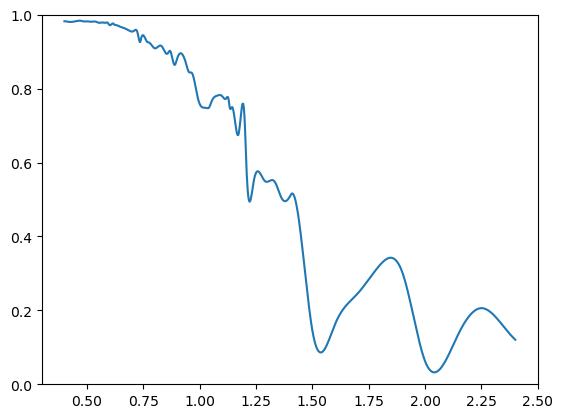

In [84]:
plt.plot(wl, spline['glacier-ice'](wl), label='Wetland')
plt.ylim(0, 1)

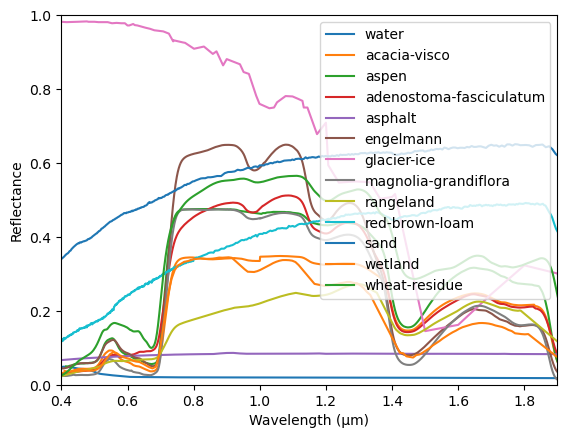

In [85]:
# plot each surface
for key in data:
    plt.plot(data[key][:, 0], data[key][:, 1], label=key)
plt.xlabel('Wavelength (μm)')
plt.ylabel('Reflectance')
plt.ylim(0, 1.)
plt.xlim(0.4, 1.9)
plt.legend()

(0.05, 0.2)

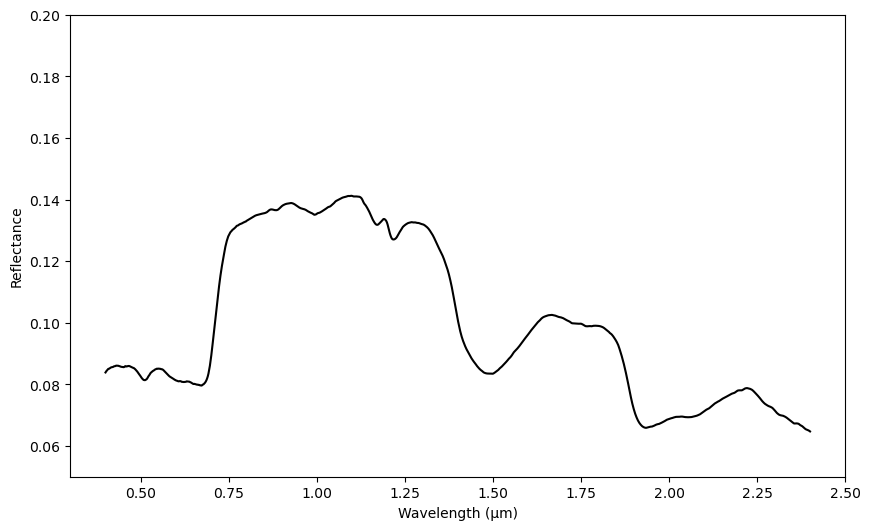

In [86]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(wl, earth_surface, label='Earth Surface', color='black')
plt.xlabel('Wavelength (μm)')
plt.ylabel('Reflectance')
plt.ylim(0.05, 0.2)

In [87]:
# Save the earth surface spectrum
earth_surface_spectrum = np.column_stack((wl, earth_surface))
np.savetxt('data/earth_surface_spectrum.csv', earth_surface_spectrum, delimiter=',', header='Wavelength (μm), Reflectance', comments='')

In [61]:
earth_xr = xr.open_dataset(file_path, engine='h5netcdf', group='MOD12C1/Data Fields', decode_times=False)

In [119]:
# Calculate the latitude weighting
latitudes = np.linspace(-90, 90, earth_xr.dims['YDim:MOD12C1'])
latitude_weights = np.cos(np.radians(latitudes))

# Normalize the weights
latitude_weights /= latitude_weights.sum()

# Apply the latitude weighting to calculate the weighted percent coverage
weighted_land_cover_percent = np.sum(np.sum(earth_xr['Land_Cover_Type_1_Percent'].values, axis=1) * latitude_weights[:, np.newaxis], axis=0)

# Normalize the weighted land cover percentages
weighted_land_cover_percent /= weighted_land_cover_percent.sum()

# Display the results
for i, percent in enumerate(weighted_land_cover_percent):
    print(f"Land Cover Type {i}: {percent:.3f}%")

print(sum(weighted_land_cover_percent))

Land Cover Type 0: 0.716%
Land Cover Type 1: 0.005%
Land Cover Type 2: 0.024%
Land Cover Type 3: 0.001%
Land Cover Type 4: 0.005%
Land Cover Type 5: 0.009%
Land Cover Type 6: 0.001%
Land Cover Type 7: 0.026%
Land Cover Type 8: 0.022%
Land Cover Type 9: 0.031%
Land Cover Type 10: 0.061%
Land Cover Type 11: 0.003%
Land Cover Type 12: 0.023%
Land Cover Type 13: 0.002%
Land Cover Type 14: 0.003%
Land Cover Type 15: 0.029%
Land Cover Type 16: 0.040%
0.9999999999999997


In [107]:
latitude_weights

array([2.67250739e-20, 3.80983379e-07, 7.61966467e-07, ...,
       7.61966467e-07, 3.80983379e-07, 2.67250739e-20])

In [111]:
earth_xr['Land_Cover_Type_1_Percent'].values[0].shape

(7200, 17)

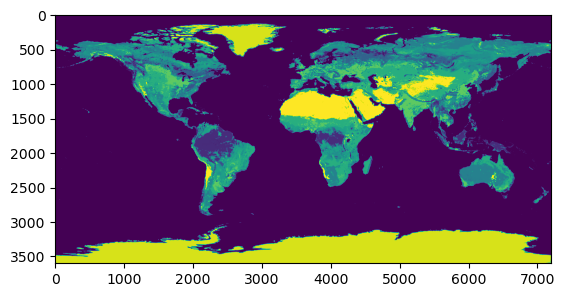

In [112]:
plt.imshow(earth_xr['Majority_Land_Cover_Type_1'].values)

In [115]:
np.sum(earth_xr['Land_Cover_Type_1_Percent'].values, axis=1).shape

(3600, 17)